In [60]:
import numpy as np
import cairo
from random import random, choice
import matplotlib.pyplot as plt

In [61]:
from itertools import product
colors = list(product((0,1), (0,1), (0,1)))[1:]

In [62]:
def make_star(w=200, h=200):
  img = np.zeros(shape=(h, w), dtype=np.uint32)
  with cairo.ImageSurface.create_for_data(img, cairo.FORMAT_ARGB32, w, h) as surface:
      context = cairo.Context(surface)
      context.set_antialias(cairo.Antialias.BEST)
      context.set_source_rgb(0,0,0)
      context.fill()
      x1, y1 = random(), random()
      x2, y2 = random(), random()
      r = random()
      print(f"c1:{x1},{y1}, c2:{x2},{y2}, r:{r}")
      pat = cairo.RadialGradient(x1, y1, 0, x2, y2, r)
      pat.set_matrix(cairo.Matrix(xx=1/w, yy=1/h))
      pat.add_color_stop_rgb(0, *choice(colors))
      pat.add_color_stop_rgb(1, 0, 0, 0)
      context.set_source(pat)
      context.scale(w, h)
      context.rectangle(0, 0, 1, 1)
      context.fill()
  r=(img >>16) & 0xff
  g=(img >>8) & 0xff
  b=img & 0xff
  return np.stack([r.astype(np.uint8),g.astype(np.uint8),b.astype(np.uint8)], axis=2)

img = make_star()

c1:0.49196304189888895,0.6024138842237146, c2:0.6802485891050564,0.21692270489824805, r:0.5775736433733232


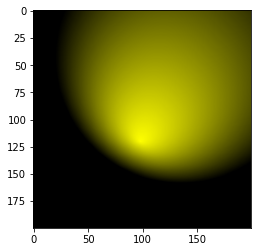

In [63]:
plt.imshow(img)

In [64]:
def rggb(img):
  r_m = np.zeros(shape=img.shape[:2], dtype=np.uint8)
  r_m[0::2, 0::2] = 1
  g1_m = np.zeros(shape=img.shape[:2], dtype=np.uint8)
  g1_m[0::2, 1::2] = 1
  g2_m = np.zeros(shape=img.shape[:2], dtype=np.uint8)
  g2_m[1::2, 0::2] = 1
  b_m = np.zeros(shape=img.shape[:2], dtype=np.uint8)
  b_m[1::2, 1::2] = 1

  return (img[:,:,0] * r_m) + (img[:,:,1] * g1_m) + (img[:,:,1] * g2_m) + (img[:,:,2] * b_m)

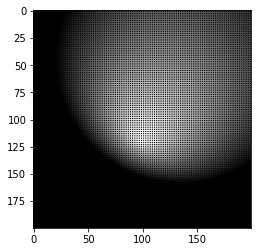

In [65]:
img_rggb = rggb(img)
plt.imshow(img_rggb, cmap='gray')

In [66]:
plt.imsave('test_rggb.png', img_rggb, dpi=300, cmap='gray')

In [67]:
img_rggb.dtype

dtype('uint8')

In [68]:
import bilinear
output_img = bilinear.debayer_bilinear(img_rggb)

In [69]:
output_img.dtype

dtype('float32')

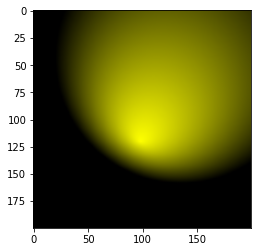

In [70]:
plt.imshow(output_img)

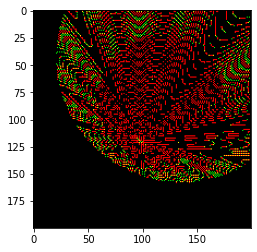

In [71]:
plt.imshow((output_img * 255).astype(np.uint8)-img)

In [72]:
import torch
from debayer_model import DebayerModel
dm = DebayerModel()
weights = torch.load("../weights/weights_00024.pth")
dm.load_state_dict(weights)


<All keys matched successfully>

In [73]:
print(weights)

OrderedDict([('k.weight', tensor([[[[ 2.7033e-01,  4.9770e-01,  2.3075e-01],
          [ 4.9929e-01,  9.9944e-01,  5.0038e-01],
          [ 2.2933e-01,  5.0229e-01,  2.6969e-01]],

         [[-1.7809e-04,  6.6957e-05, -2.1784e-04],
          [ 1.2059e-04,  3.3514e-04, -1.7472e-05],
          [-1.6095e-04,  4.9611e-05, -2.8573e-04]],

         [[ 5.4520e-04, -5.9033e-04,  5.3877e-04],
          [ 1.8556e-04, -6.3220e-04,  8.8395e-05],
          [ 5.4319e-04, -6.7672e-04,  5.2452e-04]]],


        [[[-3.5896e-04, -4.7264e-04, -3.7611e-04],
          [ 9.1147e-04,  5.7244e-04,  8.4670e-04],
          [-7.8525e-05,  2.0004e-04, -1.0761e-04]],

         [[ 1.4522e-01,  2.9192e-01,  1.4576e-01],
          [ 2.0781e-01,  4.1892e-01,  2.1001e-01],
          [ 1.4483e-01,  2.9032e-01,  1.4480e-01]],

         [[ 4.0140e-03,  7.6662e-04, -2.3444e-03],
          [-7.4671e-05, -2.2596e-05, -1.5204e-04],
          [-3.0772e-03,  3.4079e-04,  3.5270e-03]]],


        [[[-1.4314e-02, -2.9014e-04,  1.

In [74]:
bayered = img_rggb.astype(np.float32)
bayered = np.expand_dims(np.expand_dims(bayered, axis=0), axis=0)
bayered = bayered / 255.0

In [75]:
bayered.shape

(1, 1, 200, 200)

In [76]:
rgb_f = dm(torch.tensor(bayered))

In [77]:
rgb_i = (rgb_f * 255.0).detach().numpy().astype(np.uint8)

In [78]:
rgb_i.shape

(1, 3, 200, 200)

In [79]:
rgb_img = np.transpose(rgb_i[0], axes=(1, 2, 0))
print(rgb_img.shape)

(200, 200, 3)


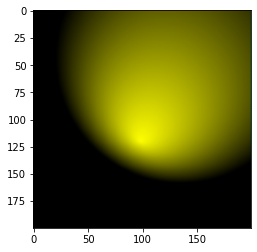

In [80]:
plt.imshow(rgb_img)

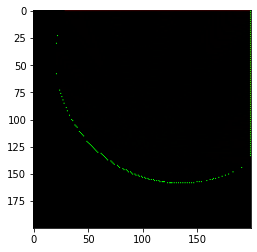

In [81]:
plt.imshow((output_img * 255).astype(np.uint8)-rgb_img)